## Digital approach to solving a QUBO: using QAOA, wsQAOA and Linear Entanglement Ansatz.

In [1]:
# General imports
import numpy as np
import pickle
from pathlib import Path
import sys
BASE_PATH = str(Path.cwd().parent.parent)
sys.path.append(BASE_PATH)

# Pre-defined ansatz circuit, operator class
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit.primitives import BackendSampler
from qiskit import transpile 
from qiskit_aer import AerSimulator

from aquapointer.digital.qubo import Qubo
from aquapointer.digital.vqe import VQE
from aquapointer.digital.qubo_utils import get_ising_hamiltonian
from aquapointer.digital.ansatz import QAOA_ansatz
from aquapointer.density_canvas.DensityCanvas import DensityCanvas, Lattice

First we need some helper functions to load all the 3D RISM slices of some protein and (scaled) register positions of the corresponding QPU. Then we use Qubo to compute the corresponding QUBO matrices and Ising Hamiltonians.

In [2]:
DENS_DIR = "/aquapointer/data/MUP1/MUP1_logfilter8_slices/"
PP_DIR = "/aquapointer/data/MUP1/MUP1_logfilter8_points/"
REG_DIR = "/aquapointer/registers/"

def load_density_slices(path: str) -> list[np.ndarray]:
    r"""The 3D-RISM density slices are saved as pickled files in the folder MUP1.
    They are indexed by a number (see d_list) which represents the distance in Angstrom
    from the central slice. This function loads the files.

    Args:
        path: Path to 3D-RISM density slices files.

    Returns:
        List of numpy arrays containing the slices.
    """
    d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    basename = "_density_slice_MUP1_logfilter8.p"
    densities = []
    for d in d_list:
        filename = path + f"d{d}" + basename
        with open(filename, 'rb') as file_in:
            densities.append(pickle.load(file_in))
            
    return densities


def load_plane_points(path: str) -> list[np.ndarray]:
    r"""Load slice coordinates (these are 3D coordinates in
    angstroms, they are needed at the very end to map
    excited qubits to positions in the protein cavity).

    Args:
        path: Path to plane points files.
    
    Returns:
        List of numpy arrays containing the plane points.
    """
    d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    basename = "_plane_points_MUP1.p"
    points = []
    for d in d_list:
        filename = path + f"d{d}" + basename
        with open(filename, 'rb') as file_in:
            points.append(pickle.load(file_in))
    
    return points

def load_register_positions(path: str) -> list[np.ndarray]:
    r"""The register associated to each slice can be found in the folder nb/registers.
    - position_<#>.npy: the positions of the qubits in micrometers, as if they were in the QPU

    Args:
        path: Path to register positions files.

    Returns:
        List of numpy arrays containing the register positions.
    """
    d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    basename = "position_"
    positions = []
    for i in range(len(d_list)):
        filename = path + basename + f"{i}.npy"
        with open(filename, 'rb') as file_in:
            pos = np.load(file_in)
        positions.append(pos)
    
    return positions

def load_rescaled_register_positions(path: str) -> list[np.ndarray]:
    r"""The register associated to each slice can be found in the folder nb/registers.
    - rescaled_position_<#>.npy: the positions of the qubits on the same scale as the density slices

    Args:
        path: Path to register positions files.

    Returns:
        List of numpy arrays containing the rescaled register positions.
    """
    d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    basename = "rescaled_position_"
    rescaled_positions = []
    for i in range(len(d_list)):
        filename = path + basename+f"{i}.npy"
        with open(filename, 'rb') as file_in:
            res_pos = np.load(file_in)
        rescaled_positions.append(res_pos)
    
    return rescaled_positions

In [3]:
# First we load the density files and rescaled register positions.
densities = load_density_slices(path=BASE_PATH + DENS_DIR)
register_positions = load_register_positions(path=BASE_PATH + REG_DIR)
rescaled_register_positions = load_rescaled_register_positions(path=BASE_PATH + REG_DIR)

# Qubo computes all the qubo matrices given the 3d rism 
# files and rescaled positions of registers from LoadData.
q = Qubo(densities, rescaled_register_positions)

### Draw the density

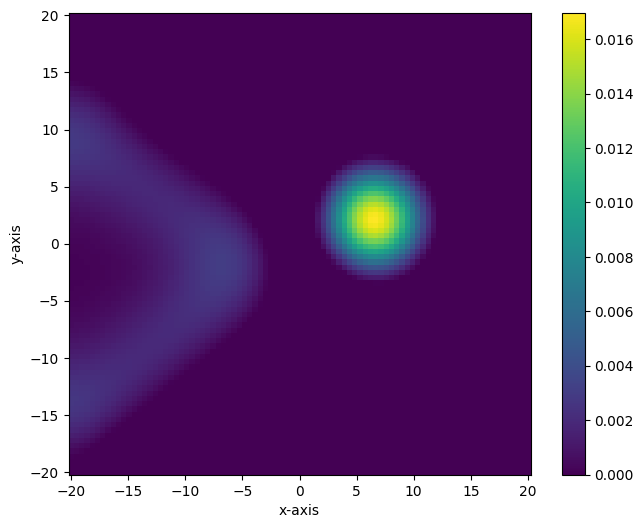

In [4]:
origin = (-20, -20)
length = 40
npoints = len(densities[0])
canvas = DensityCanvas(
    origin=origin,
    length_x=length,
    length_y=length,
    npoints_x=npoints,
    npoints_y=npoints,
)
canvas.set_density_from_slice(densities[0])
canvas.set_lattice(lattice=Lattice(register_positions[0]), centering=False)
canvas.draw(draw_lattice=False, figsize=(8,6))

### We pick the QUBO matrix corresponding to this density from the Qubo object and use that to define the ansatzes.

In [5]:
# Use the first slice as an example to solve.
qubo, ising_ham = q.qubo_hamiltonian_pairs[-1]
num_qubits = len(qubo)

# Print the qubo matrix.
qubo, qubo.shape

(array([[-0.02133358,  0.04727714,  0.04727714,  0.04727714,  0.04727714,
          0.03218907,  0.02656055,  0.01492186],
        [ 0.04727714, -0.01478681,  0.04727714,  0.03218907,  0.02656055,
          0.01492186,  0.01015968,  0.00470971],
        [ 0.04727714,  0.04727714, -0.01797982,  0.04727714,  0.03218907,
          0.02656055,  0.01492186,  0.01015968],
        [ 0.04727714,  0.03218907,  0.04727714, -0.02404681,  0.04727714,
          0.04727714,  0.03218907,  0.02656055],
        [ 0.04727714,  0.02656055,  0.03218907,  0.04727714, -0.02280619,
          0.04727714,  0.04727714,  0.03218907],
        [ 0.03218907,  0.01492186,  0.02656055,  0.04727714,  0.04727714,
         -0.02307382,  0.04727714,  0.04727714],
        [ 0.02656055,  0.01015968,  0.01492186,  0.03218907,  0.04727714,
          0.04727714, -0.01699135,  0.04727714],
        [ 0.01492186,  0.00470971,  0.01015968,  0.02656055,  0.03218907,
          0.04727714,  0.04727714, -0.0145127 ]]),
 (8, 8))

### Qubo object also has a function that computes the optimal bitstring and corresponding energy using classical brute-force approach.

In [6]:
# classical brute-force solution
solution = q.find_optimum(qubo=qubo)
solution

('00010000', -0.02404680978135616)

### For illustration, here is a drawing of the Linear Entanglement ansatz.

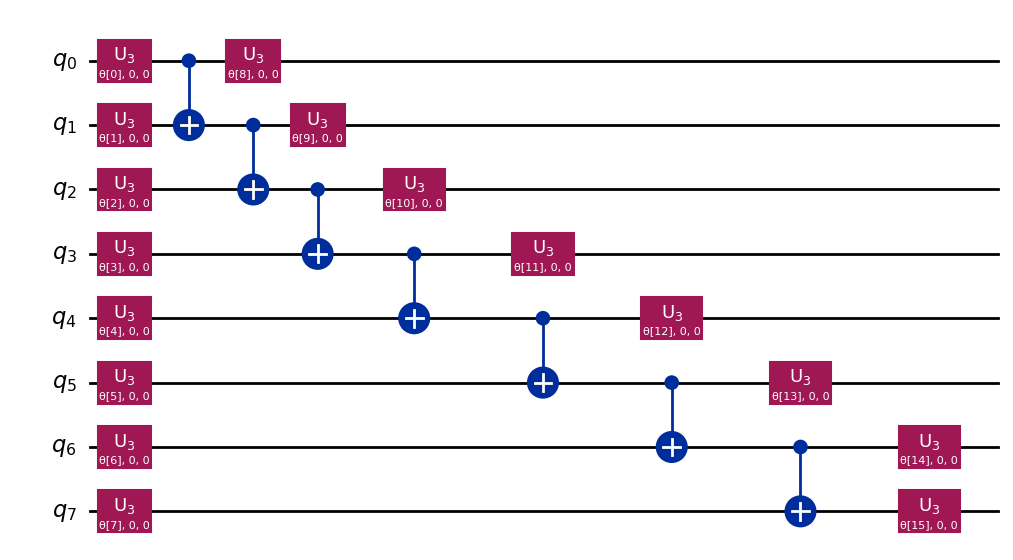

In [7]:
# Linear Entanglement ansatz circuit.
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

# Drawing of the Linear Entanglement ansatz circuit.
basis_gates=['u1', 'u2', 'u3', 'cx']
ansatz_transpiled = transpile(le_ansatz, AerSimulator(), basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
ansatz_transpiled.draw('mpl', style='iqp')

### Now that we have defined the qubo and ansatzes to be used, we use the VQE module to apply the variational approach. VQE accepts a qubo matrix, an ansatz, a sampler and initial parameters.

In [8]:
# EXAMPLE: QAQA

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

# QAOA ansatz circuit.
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

alpha = 0.95 # confidence level for CVaR

# Initial parameters for the QAOA ansatz.
beta  = [0.7977]
gamma = [0.0765]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, track_opt_solution=True)

# Run the minimization.
vqe_qaoa.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_qaoa.history

[['00010000', 0.0031, -0.02404680978135616],
 ['00010000', 0.0047, -0.02404680978135616],
 ['00010000', 0.0067, -0.02404680978135616],
 ['00010000', 0.0184, -0.02404680978135616],
 ['00010000', 0.0041, -0.02404680978135616],
 ['00010000', 0.0057, -0.02404680978135616],
 ['00010000', 0.0083, -0.02404680978135616],
 ['00010000', 0.0201, -0.02404680978135616],
 ['00010000', 0.0232, -0.02404680978135616],
 ['00010000', 0.0218, -0.02404680978135616]]

In [9]:
# EXAMPLE: LE
np.random.seed(1)

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

# Linear Entanglement ansatz circuit.
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

alpha = 0.95 # confidence level for CVaR

params_le = np.array([np.random.random()]*le_ansatz.num_parameters)
vqe_le = VQE(qubo=qubo, ansatz=le_ansatz, sampler=sampler, params=params_le, track_opt_solution=True)

# Now run the minimization procedure.
vqe_le.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_le.history

[['00010000', 0.0004, -0.02404680978135616],
 ['00010000', 0.0043, -0.02404680978135616],
 ['00010000', 0.0048, -0.02404680978135616],
 ['00010000', 0.0025, -0.02404680978135616],
 ['00010000', 0.0001, -0.02404680978135616],
 ['00010000', 0.0337, -0.02404680978135616],
 ['00010000', 0.0256, -0.02404680978135616],
 ['00010000', 0.0237, -0.02404680978135616],
 ['00010000', 0.0197, -0.02404680978135616],
 ['00010000', 0.031, -0.02404680978135616]]

### QAOA with warmstart.

In [10]:
# EXAMPLE: QAQA with warm start
np.random.seed(1)

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

qaoa_ansatz = QAOA_ansatz(qubo=qubo, warm_start=True).qaoa_ansatz

alpha = 0.95
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, track_opt_solution=True)

vqe_qaoa.run(alpha=alpha, maxiter=10)
vqe_qaoa.history

[['00010000', 0.0037, -0.02404680978135616],
 ['00010000', 0.0021, -0.02404680978135616],
 ['00010000', 0.0017, -0.02404680978135616],
 ['01000010', 0.0001, -0.011458807021203866],
 ['00010000', 0.0038, -0.02404680978135616],
 ['00010000', 0.0089, -0.02404680978135616],
 ['00010000', 0.0012, -0.02404680978135616],
 ['00000100', 0.9951, -0.023073821946831514],
 ['00010000', 0.003, -0.02404680978135616],
 ['00010000', 0.0007, -0.02404680978135616]]

## Random Gaussian mixtures

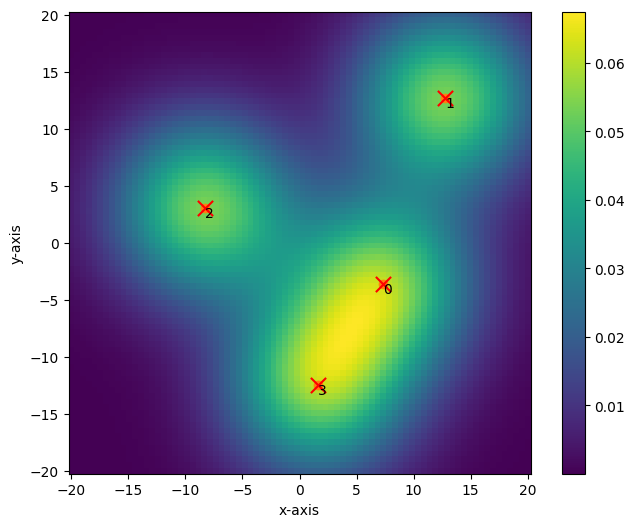

In [11]:
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.density_canvas.Lattice import Lattice
# define a canvas
origin = (-20, -20)
length = 40
npoints = 80
canvas = DensityCanvas(
    origin=origin,
    length_x=length,
    length_y=length,
    npoints_x=npoints,
    npoints_y=npoints,
)

# extract random centers with a minimal distance
# and a padding from border
seed = 6942
n_centers = 4 #number of Gaussians
min_dist = 10 #minimal distance between gaussians
padding = 6 #minimal distance of Gaussian centers from border
amplitude = 10 #amplitude of the Gaussians
variance = 30 #variance of the Gaussians

canvas.set_randomized_gaussian_density(
    n_centers = n_centers,
    amplitude = amplitude,
    variance = variance,
    minimal_distance = min_dist,
    padding = padding,
    seed = seed
)

canvas.set_lattice(lattice=Lattice(canvas.gaussian_centers), centering=False)

# To see the result, call the draw method with draw_centers=True
canvas.draw(draw_centers=True, draw_lattice=True, figsize=(8,6))

In [12]:
from aquapointer.digital.vqe import VQE
from aquapointer.digital.ansatz import QAOA_ansatz

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class
from qiskit.primitives import BackendSampler
from qiskit_aer import AerSimulator

backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

def get_qubo_coeffs(canvas):
    estimated_variance = 30
    estimated_amplitude = 10

    # canvas.set_poisson_disk_lattice(spacing=(5, 5))
    canvas.set_lattice(lattice=Lattice(canvas.gaussian_centers), centering=False)
    _ = canvas.calculate_pubo_coefficients(
            p = 2, #order of the PUBO, p=2 effectively creates a QUBO
            params = [estimated_amplitude, estimated_variance],
            efficient_qubo=True
        )
    # canvas.force_lattice_size(7)
    # canvas.draw(draw_lattice=True)
    # rescaled_positions = canvas._lattice._coords
    qubo_coeffs = canvas._pubo

    return qubo_coeffs

In [13]:
# from the qubo coefficients dictionary, create a qubo matrix:
def get_random_qubo(seed, n_centers=5):

    # define a canvas
    origin = (-20, -20)
    length = 40
    npoints = 80
    canvas = DensityCanvas(
        origin=origin,
        length_x=length,
        length_y=length,
        npoints_x=npoints,
        npoints_y=npoints,
    )
    # extract random centers with a minimal distance
    # and a padding from border
    # n_centers = 5 #number of Gaussians
    min_dist = 3 #minimal distance between gaussians
    padding = 6 #minimal distance of Gaussian centers from border
    amplitude = 10 #amplitude of the Gaussians
    variance = 30 #variance of the Gaussians

    canvas.set_randomized_gaussian_density(
        n_centers = n_centers,
        amplitude = amplitude,
        variance = variance,
        minimal_distance = min_dist,
        padding = padding,
        seed = seed
    )
    # To see the result, call the draw method with draw_centers=True
    canvas.draw(draw_centers=True, draw_lattice=True, figsize=(8,6))

    qubo = get_qubo_coeffs(canvas)
    
    qubo_matrix = np.zeros((len(qubo['coeffs'][1]), len(qubo['coeffs'][1])))

    for key in qubo['coeffs'][1].keys():
        qubo_matrix[key[0]][key[0]] = qubo['coeffs'][1][key]

    for key in qubo['coeffs'][2].keys():
        qubo_matrix[key] = qubo['coeffs'][2][key]
        qubo_matrix[key[::-1]] = qubo['coeffs'][2][key]

    return qubo_matrix

Lattice has not been defined


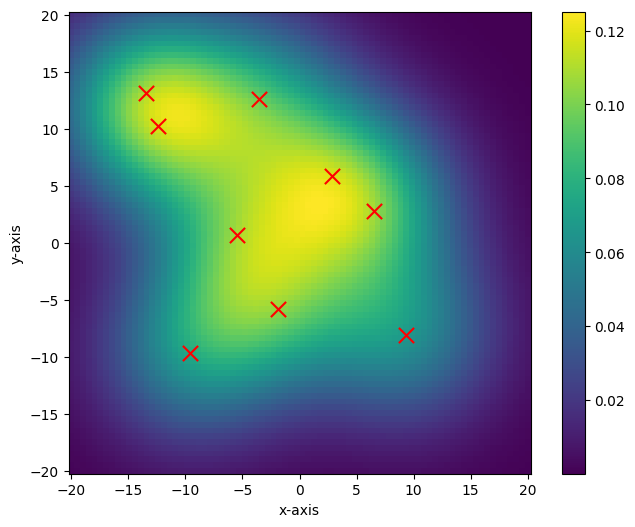

In [14]:
qubo_matrix = get_random_qubo(seed = 42, n_centers=9)

In [15]:
qaoa_ansatz = QAOA_ansatz(qubo=qubo_matrix, warm_start=True).qaoa_ansatz
beta  = [np.pi/3]#[0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [np.pi/3]#[0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params_qaoa = np.array(beta+gamma)

vqe_wsqaoa = VQE(qubo=qubo_matrix, ansatz=qaoa_ansatz, sampler=sampler, params=params_qaoa, track_opt_solution=False)

vqe_wsqaoa.run(alpha=0.95, maxiter=15)

vqe_wsqaoa.history

[[1.0, -0.007689361673714184],
 [1.0, -0.009158802628730478],
 [1.0, -0.009151875582954673],
 [1.0, -0.11356881670260904],
 [1.0, -0.006368247615709971],
 [1.0, -0.012452987119429859],
 [1.0, -0.018548012805034073],
 [1.0, -0.07965841063284974],
 [1.0, -0.08538395556450801],
 [1.0, -0.05660519272405761],
 [1.0, -0.3531755956783973],
 [1.0, -0.353287829649282],
 [1.0, -0.38883402885122775],
 [1.0, -0.3233441837078919],
 [1.0, -0.24229946323827245]]

In [16]:
qaoa_ansatz = QAOA_ansatz(qubo=qubo_matrix, warm_start=False).qaoa_ansatz
beta  = [np.pi/3]#[0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [np.pi/3]#[0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params_qaoa = np.array(beta+gamma)

vqe_qaoa = VQE(qubo=qubo_matrix, ansatz=qaoa_ansatz, sampler=sampler, params=params_qaoa, track_opt_solution=False)

vqe_qaoa.run(alpha=0.95, maxiter=15)

vqe_qaoa.history

[[1.0, -0.00789830168744059],
 [1.0, -0.009101697880916922],
 [1.0, -0.008924454264828859],
 [1.0, -0.00653648123861713],
 [1.0, -0.006576994404119164],
 [1.0, -0.005757904037711165],
 [1.0, -0.005641140409618961],
 [1.0, -0.005496269256598728],
 [1.0, -0.00567556575499011],
 [1.0, -0.005610294763313337],
 [1.0, -0.005552317182528374],
 [1.0, -0.005549211218410573],
 [1.0, -0.005582091924591221],
 [1.0, -0.0055932973979452025],
 [1.0, -0.005555119858693513]]

In [17]:
# classical brute-force solution
from aquapointer.digital.qubo_utils import find_optimum
solution = find_optimum(qubo=qubo_matrix)
solution

('111001110', -4.304706868417688)